# Simulating Coded Aperture Mask and PSF

We first generate the mask from MLS sequences as in the FlatCam paper: https://arxiv.org/abs/1509.00116

And then we simulate its PSF using our same forward model: convolution between (1) spherical waves impinging on the mask and (2) free space propagation kernel.

In [1]:
from scipy.signal import max_len_seq
import matplotlib.pyplot as plt
import numpy as np
from lensless.plot import plot_image

# Generate mask from MLS sequence

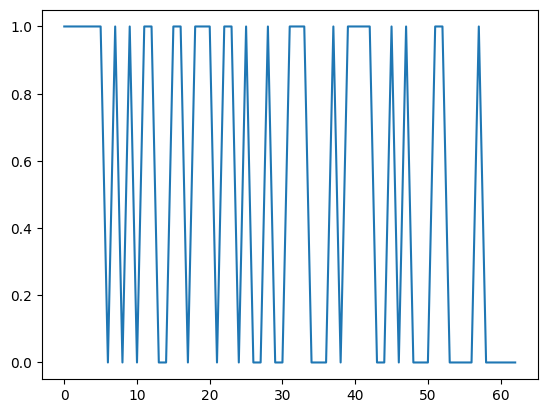

In [3]:
crop_fact = 0.8   # same as other lensless
sensor = "rpi_hq"

# length given by 2**nbits - 1
nbits = 8   # length 255
nbits = 7   # length 127
nbits = 6   # length 63, for feature size of 30um like min size in FlatCam paper

scene2mask = 0.4

mask2sensor = 0.004
mask2sensor = 0.5e-3   # in FlatCam paper

# generate MLS sequence in FlatCam paper

h = max_len_seq(nbits=nbits)[0]
# print(len(h))
# print(sum(h))   # check number of openings

plt.plot(h)


126
(126, 126)


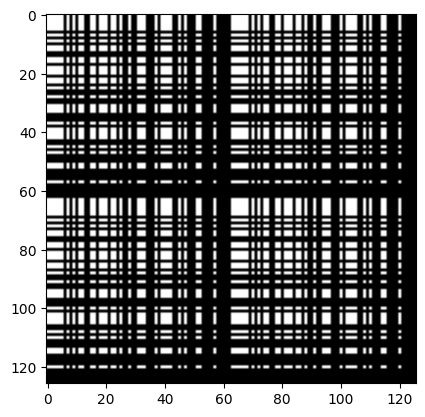

In [4]:
# repeat and outer product for the mask
h_r = np.r_[h, h]
print(len(h_r))

mask = np.outer(h_r, h_r)
print(mask.shape)

# undiffracted mask
plot_image(mask, normalize=True);

# Simulate mask on Raspberry Pi sensor

resize mask for sensor resolution and with cropping specified above

{'diagonal': 0.007857,
 'pixel_size': array([1.55e-06, 1.55e-06]),
 'shape': array([3040, 4056]),
 'size': array([0.00471222, 0.00628709])}


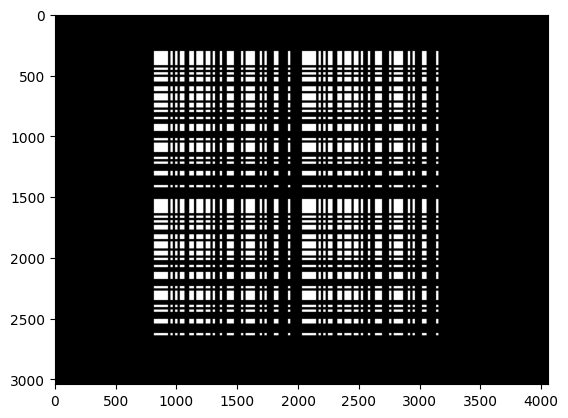

In [15]:
from lensless.util import resize
import cv2
from waveprop.devices import sensor_dict, SensorParam
from pprint import pprint


# sensor dimensions
sensor_param = sensor_dict[sensor]
pprint(sensor_param)

# in FlatCam they use 30-100 um features
min_dim = min(sensor_param[SensorParam.SHAPE])
shape = tuple((np.array([min_dim, min_dim]) * crop_fact).astype(int))
mask_resize = resize(mask, shape=shape, interpolation=cv2.INTER_NEAREST)

# pad to sensor resolution
padding = sensor_param[SensorParam.SHAPE] - mask_resize.shape
# print(padding)
left = padding[0] // 2
right = padding[0] - left
top = padding[1] // 2
bottom = padding[1] - top
mask_resize = np.pad(mask_resize, pad_width=((left, right), (top, bottom)))

# undiffracted mask
plot_image(mask_resize, normalize=True);

In [18]:
## in FlatCam they use 30-100 um features

# estimate of feature size
# fact = shape[1] / mask.shape[1]
# print("resize fact :", fact)
mask_overlap_size = shape[1] * d1[1]
# print(mask_overlap_size)
feature_size = mask_overlap_size / len(h_r) * 1e6
print("feature size [um] :", feature_size)

feature size [um] : 29.918829678289065


# simulate PSF

In [23]:
from pprint import pprint
from waveprop.spherical import spherical_prop
from waveprop.color import ColorSystem
from waveprop.rs import angular_spectrum
import time

# -- spherical propagation from object to mask
color_system = ColorSystem.rgb()
spherical_wavefront = spherical_prop(
    in_shape=input_shape,
    d1=d1,
    wv=color_system.wv,
    dz=scene2mask,
    return_psf=True,
    is_torch=False,
    dtype=np.float32
)

# -- apply mask
u_in = mask_resize * spherical_wavefront

# -- diffraction / free-space to sensor
psfs = np.zeros(u_in.shape, dtype=np.complex64)
start_time = time.time()
for i in range(color_system.n_wavelength):
    psfs[i], _, _ = angular_spectrum(
        u_in=u_in[i],
        wv=color_system.wv[i],
        d1=d1,
        dz=mask2sensor,
        dtype=np.float32
    )
    print(time.time() - start_time)

psfs = psfs / np.linalg.norm(psfs.flatten())



7.5278685092926025
14.953745365142822
22.371453046798706


In [24]:
# intensity PSF
psf_int = np.abs(psfs) ** 2
print(psf_int.shape)

(3, 3040, 4056)


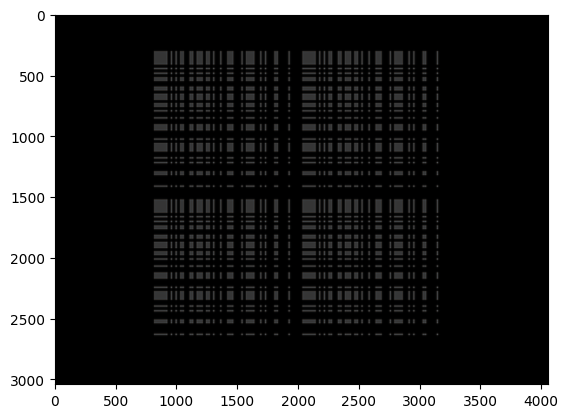

In [25]:
psf_reshape = np.transpose(psf_int, axes=(1, 2, 0))

# diffracted mask
plot_image(psf_reshape, normalize=True);

# save

as viewable image (8 bit)

In [26]:
from datetime import datetime
timestamp = datetime.now().strftime("%d%m%Y_%Hh%M")
from lensless.util import print_image_info

bit_depth = 8   # for viewable image
out_dtype = dtype=np.uint8

# cast to uint as on sensor
psf_sim = psf_reshape / psf_reshape.max()
psf_sim *= 2**bit_depth - 1
psf_sim = psf_sim.astype(out_dtype)
print_image_info(psf_sim)

fp = f"simulated_mls{len(h)}_mask2sensor{mask2sensor}_{timestamp}_{bit_depth}bit.png"
cv2.imwrite(fp, cv2.cvtColor(psf_sim, cv2.COLOR_RGB2BGR))
print("Saved simulated PSF to : ", fp)

dimensions : (3040, 4056, 3)
data type : uint8
max  : 255
min  : 0
mean : 6.374928468545624
Saved simulated PSF to :  simulated_mls63_mask2sensor0.0005_17112022_09h28_8bit.png


as on Raspberry Pi with 12 bit precision

In [27]:
from datetime import datetime
timestamp = datetime.now().strftime("%d%m%Y_%Hh%M")
from lensless.util import print_image_info


bit_depth = 12     # like on Raspberry pi
out_dtype = dtype=np.uint16

# cast to uint as on sensor
psf_sim = psf_reshape / psf_reshape.max()
psf_sim *= 2**bit_depth - 1
psf_sim = psf_sim.astype(out_dtype)
print_image_info(psf_sim)

fp = f"simulated_mls{len(h)}_mask2sensor{mask2sensor}_{timestamp}_{bit_depth}bit.png"
cv2.imwrite(fp, cv2.cvtColor(psf_sim, cv2.COLOR_RGB2BGR))
print("Saved simulated PSF to : ", fp)

dimensions : (3040, 4056, 3)
data type : uint16
max  : 4095
min  : 0
mean : 105.11123752119451
Saved simulated PSF to :  simulated_mls63_mask2sensor0.0005_17112022_09h28_12bit.png
